In [ ]:
! pip install zstandard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 18.8 MB/s eta 0:00:00


In [ ]:
# importing Libraries
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm
tqdm.pandas()

In [ ]:
# small adjustment to make the code work in Colab
log_info = print

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change this path as per the file path of cancer_submissions (1) in your drive
FOLDER_PATH = "/content/drive/MyDrive/Syracuse University/IST 736 Text Mining/Project"
submissions=pd.read_json(f'{FOLDER_PATH}/cancer_submissions (1).zst', compression=dict(method='zstd'), \
                         lines=True)

In [ ]:
submissions.head()

,archived,author,author_flair_background_color,author_flair_css_class,author_flair_text,author_flair_text_color,brand_safe,can_gild,contest_mode,created_utc,...,treatment_tags,upvote_ratio,is_created_from_ads_ui,retrieved_utc,top_awarded_type,url_overridden_by_dest,poll_data,gallery_data,is_gallery,call_to_action
0,1.0,[deleted],,None,None,dark,0.0,0.0,0.0,1225060992,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,[deleted],,None,None,dark,0.0,0.0,0.0,1240211158,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,cathyz,None,None,None,None,0.0,1.0,0.0,1246264550,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,chris99460,None,None,None,None,0.0,1.0,0.0,1247023273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,ricemilk,None,None,None,None,0.0,1.0,0.0,1247845780,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
submissions['body'] = submissions.title + " " + submissions.selftext # Combining Title and SelfText to obtain a document

In [ ]:
for i in submissions.columns:
    if 'id' in i:
        print(i)

hidden
hide_score
id
is_video
subreddit_id
thumbnail_width
from_id
author_flair_template_id
link_flair_template_id
url_overridden_by_dest


In [ ]:
submissions = submissions[['id', 'url', 'title', 'selftext', 'body']]

In [ ]:
len(submissions) # Total Number of Submissions to be Analyzed

79741

# LDA

In [ ]:
import gensim.corpora as corpora
import gensim
from gensim.models.coherencemodel import CoherenceModel

# Function to create LDA Model and return it along with corpus and texts
def create_lda_model(df, col, num_topics):
    data_words = list(df[col])
    log_info(f"creating corpus")
    id2word = corpora.Dictionary(data_words)
    texts = data_words
    corpus = [id2word.doc2bow(text) for text in texts]
    log_info(f"creating model :: {num_topics = }")
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                          workers = 2)
    return lda_model, corpus, texts

In [ ]:
def texts_generator(texts):
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1

    texts = [
        [token for token in text if frequency[token] > 1]
        for text in texts
    ]
    return texts

def get_plot_coherence_scores_c(df, col, num_topics): # using coherence metric
    results = []

    # running the loop num_topics - 4 number of times to calculate coherence scores for each num_topi, t
    for t in range(4, num_topics):
        lda_model, _ , texts  = create_lda_model(df, col, t)
        texts = texts_generator(texts)
        # corpus_lda = lda_model[corpus]

        cm = CoherenceModel(model=lda_model, texts=texts, coherence='c_v') # takes the model and calculates coherence among the K topics
        score = cm.get_coherence()
        tup = t, score
        results.append(tup)

    results = pd.DataFrame(results, columns=['topic', 'score']) # collating the results

    s = pd.Series(results.score.values, index=results.topic.values)
    _ = s.plot() # Plotting the scores against ts

    return results

In [ ]:
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

def stop_word_treatment(tokens):
    stop_word_list = stop_words
    tokens = [word for word in tokens if word not in stop_word_list]
    return tokens

def tokenize_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word != '' and len(word) > 2]
    return tokens

def final_token_filter(tokens):
    return [word for word in tokens if (len(word) > 2) | (word.isdigit())]

def clean_review(text):
    # text preprocessing : Tokenization, Lemmatization, Stop Words Removal, Small Words Removal
    tokens = tokenize_text(text)
    tokens = lemmatize_text(tokens)
    tokens = stop_word_treatment(tokens)
    tokens = final_token_filter(tokens)
    return tokens

In [ ]:
clean_review("My Name is Aadil Zikre")

['name', 'aadil', 'zikre']

In [ ]:
submissions['clean_text'] = submissions.body.progress_apply(clean_review)

100%|██████████| 79741/79741 [02:11<00:00, 605.95it/s]
<ipython-input-45-849fbf2ed3ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions['clean_text'] = submissions.body.progress_apply(clean_review)


creating corpus
creating model :: num_topics = 4
creating corpus
creating model :: num_topics = 5
creating corpus
creating model :: num_topics = 6
creating corpus
creating model :: num_topics = 7
creating corpus
creating model :: num_topics = 8
creating corpus
creating model :: num_topics = 9
creating corpus
creating model :: num_topics = 10
creating corpus
creating model :: num_topics = 11
creating corpus
creating model :: num_topics = 12
creating corpus
creating model :: num_topics = 13
creating corpus
creating model :: num_topics = 14
creating model :: num_topics = 15


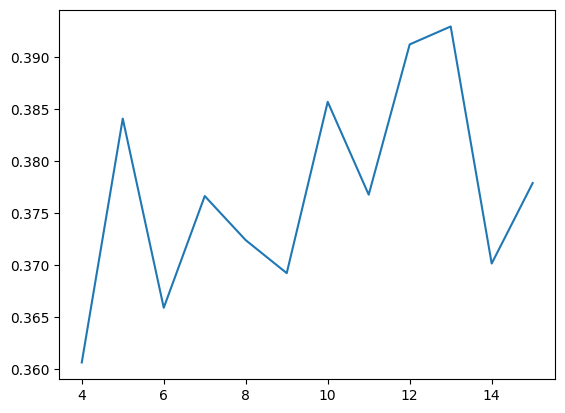

In [ ]:
results = get_plot_coherence_scores_c(submissions, 'clean_text', 16)

In [ ]:
# 13 is the optimum number of topics

In [ ]:
lda_model, corpus, texts = create_lda_model(submissions, "clean_text", 13)

creating corpus
creating model :: num_topics = 13


In [ ]:
# lda_model.print_topics()

In [ ]:
training_topics = lda_model.get_document_topics(corpus)

In [ ]:
submissions['all_topics'] = list(training_topics)

<ipython-input-73-791af0ceb1b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions['all_topics'] = list(training_topics)


In [ ]:
submissions['top_topic'] = submissions.all_topics.apply(lambda x : sorted(x, key=lambda x: x[1], reverse=True)[0][0]) # Assigning the top Topic to each doc

<ipython-input-76-f6865b098ed2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions['top_topic'] = submissions.all_topics.apply(lambda x : sorted(x, key=lambda x: x[1], reverse=True)[0][0])


In [ ]:
# submissions.to_parquet(f"{FOLDER_PATH}/processed_file_13_topics.parquet", index=False)

In [ ]:
submissions = pd.read_parquet(f"{FOLDER_PATH}/processed_file_13_topics.parquet") # Saving a checkpoint

In [ ]:
submissions.head()

,id,url,title,selftext,body,clean_text,all_topics,top_topic
0,79ifz,http://www.slate.com/id/2202762/pagenum/all/,Oral chemotherapy - Why oral cancer drugs are ...,,Oral chemotherapy - Why oral cancer drugs are ...,"[oral, chemotherapy, oral, cancer, drug, 're, ...","[[7.0, 0.5994756817817688], [9.0, 0.2944949865...",7
1,8dtda,http://www.bloomberg.com/apps/news?pid=2060108...,Smokers’ Urine May Give Cancer Alert Early Eno...,[deleted],Smokers’ Urine May Give Cancer Alert Early Eno...,"[smoker, urine, may, give, cancer, alert, earl...","[[2.0, 0.4599960744380951], [7.0, 0.3920481503...",2
2,8wkqn,http://articles.mercola.com/sites/articles/arc...,Stop! Read This BEFORE You Get that Mammogram…,,Stop! Read This BEFORE You Get that Mammogram…,"[stop, read, get, mammogram…]","[[0.0, 0.019234083592891693], [1.0, 0.01923405...",12
3,8z5ne,http://www.apluswriter.com/promote-breast-canc...,Promote Breast Cancer Awareness,,Promote Breast Cancer Awareness,"[promote, breast, cancer, awareness]","[[0.0, 0.015388743951916695], [1.0, 0.01538869...",7
4,924l8,http://i2y.com/,I'm Too Young For This! : Empowering Young Adu...,,I'm Too Young For This! : Empowering Young Adu...,"[young, empowering, young, adult, affected, ca...","[[0.0, 0.01099445205181837], [1.0, 0.010994419...",7


In [ ]:
submissions.top_topic.value_counts() # Topic Wise count of Documents

7     15400
6      8222
3      7713
12     7660
9      6858
10     6323
8      5802
2      5722
5      4659
0      4647
1      4397
4      1360
11      978
Name: top_topic, dtype: int64

In [ ]:
# Printing 10 Random Documents in each Topic to understand what it is about.
for i in range(0, 13):
    print(f"---------------------------------- TOPIC : {i} --------------------------------------")
    temp = submissions.query(f"top_topic == {i}")
    temp = temp.sample(10)
    for idx, j in enumerate(temp.body.values, start=1):
        print(f"({idx}) --> {j}")
    print(f"-------------------------------------------------------------------------------------")

---------------------------------- TOPIC : 0 --------------------------------------
(1) --> rahim kanseri 
(2) --> Help - Costs for Multiple Myeloma drugs I'm a pharmacist and know first hand the games manufacturers play for cash pricing.  Ironically I find myself on the other end of the stick this time.  

My grandfather has been diagnosed with stage 3 multiple myeloma.  To complicate this issue, he is stuck in china with a fractured lumber vertebrae.  My grandfather is a US resident / Chinese citizen but he has no insurance.  

The Chinese doctors have recommended velcade (bortezomib) and revlimid (lenalidomide) for the initial induction phase of his treatment.  Simply put, our entire family cannot afford the 15k USD per 4 week cycle that this therapy costs.  

I've been looking into clinical trials (small number posted for china), calling the manufacturers Monday and seeing if they have a PAP for My grandfather to use, and I'd even consider traveling to Mexico or India to buy these 

In [ ]:
"""
Topics to look out for:
1. Managing Pain
2. Treatment Advice
3. Support
4. Rant
5. Marijuana (this was added after the initial presenation, as such its analysis is done only with zero shot method)
"""

"""
Topics Found:
0. Advertisements or News Articles
1. Seeking Advise
2. Update on conditions : Beat Cancer, Lost Someone.
3. Mix of Articles and General Queries
4. Ads Unrelated to Cancer Treatments
5. Emotional Support Seeking
6. Advice Seeking from people who have experienced the same
7. Random Posts/Articles with short titles
8. Venting : Sharing things without an expectation of advice/support
9. Seeking advice for closed ones diagnosed with cancer
10. Sharing/ Updating on Stuff
11. Tech Articles on Cancer Treatment Breakthroughs
12. Mix of Venting and Emotional Support
"""